In [ ]:
!pip install opendatasets

In [ ]:
#=======================================
# Step-1: Import Libraries
#=======================================

import warnings
warnings.filterwarnings('ignore')

import os
from glob import glob

import opendatasets as od

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from tensorflow.keras.metrics import Precision,Recall

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix


In [ ]:
#======================================
# Step-2: Load Dataset
#======================================
od.download('https://www.kaggle.com/datasets/orvile/pmram-bangladeshi-brain-cancer-mri-dataset')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chanchalsaha7
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/orvile/pmram-bangladeshi-brain-cancer-mri-dataset


100%|██████████| 161M/161M [00:00<00:00, 1.49GB/s]

In [ ]:
#==========================================================
# Step-3: Create Data frame using each file path & label
#==========================================================

base_dir='/content/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Augmented Data'
pattern=os.path.join(base_dir,'**','*.jpg')

filepaths=glob(pattern,recursive=True)

df=pd.DataFrame({
    'path':filepaths,
    'label':[os.path.basename(os.path.dirname(f)) for f in filepaths]
})

df


,path,label
0,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Pituitary
1,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Pituitary
2,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Pituitary
3,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Pituitary
4,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Pituitary
...,...,...
5999,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Meningioma
6000,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Meningioma
6001,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Meningioma
6002,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Meningioma


In [ ]:
#unique label
df['label'].unique()

array(['512Pituitary', '512Normal', '512Glioma', '512Meningioma'],
      dtype=object)

In [ ]:
# label cleaning

df['label']=df['label'].map({
    '512Glioma':'Glioma',
    '512Meningioma':'Meningioma',
    '512Pituitary':'Pituitary',
    '512Normal':'Normal'
})

In [ ]:
# check update label
df['label'].unique()

array(['Pituitary', 'Normal', 'Glioma', 'Meningioma'], dtype=object)

In [ ]:
#======================================
# Image preprocessing( Augmentation)
#======================================

train_gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    fill_mode='nearest'
)

val_gen=ImageDataGenerator(rescale=1./255)

In [ ]:
#========================================
# Model build up function
#========================================

def build_model():

    base_model=VGG16(weights='imagenet',include_top=False,input_shape=IMG_SIZE+(3,),name='vgg19')
    base_model.trainable=False
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(512,activation='relu')(x)
    x=Dropout(0.2)(x)
    x=BatchNormalization()(x)
    outputs=Dense(4,activation='softmax')(x)

    model=Model(base_model.input,outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy',Precision(),Recall()]
    )
    return model,base_model

In [ ]:
#=====================================
# Step-4: K fold split
#=====================================

x=df['path'].values
y=df['label'].values

kf=KFold(n_splits=5,shuffle=True,random_state=42)

fold_no=1
results=[]

for train_idx,val_idx in kf.split(x):
    train_df=df.iloc[train_idx]
    val_df=df.iloc[val_idx]



    BATCH_SIZE=32
    SEED=42
    IMG_SIZE=(224,224)

    train_image=train_gen.flow_from_dataframe(
        train_df,
        x_col='path',
        y_col='label',
        target_size=IMG_SIZE,
        shuffle=True,
        batch_size=BATCH_SIZE,
        seed=SEED,
        class_mode='categorical'
    )

    val_image=val_gen.flow_from_dataframe(
        val_df,
        x_col='path',
        y_col='label',
        target_size=IMG_SIZE,
        shuffle=False,
        batch_size=BATCH_SIZE,
        seed=SEED,
        class_mode='categorical'
    )

    model,base_model=build_model()
    print('Fold-no: ', fold_no)

    er=EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    lr=ReduceLROnPlateau(
        monitor='val_loss',
        patience=2,
        factor=0.2,
        min_lr=1e-7,
        verbose=1
    )
    ck=ModelCheckpoint(
        f'best_model{fold_no}.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1

    )


    model.fit(
        train_image,
        validation_data=val_image,
        epochs=10,
        callbacks=[ck,er,lr],
        verbose=1
    )

    base_model.trainable=True

    for layer in model.layers[:-30]:
        layer.trainable=False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy',Precision(),Recall()]

    )
    model.fit(
        train_image,
        validation_data=val_image,
        epochs=10,
        callbacks=[ck,lr,er],
        verbose=1
    )

    results.append(model.evaluate(val_image))
    fold_no+=1

print('\n final k-fold Results: ',results)




Found 4803 validated image filenames belonging to 4 classes.
Found 1201 validated image filenames belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Fold-no:  1
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.5956 - loss: 0.9815 - precision: 0.6844 - recall: 0.5129
Epoch 1: val_accuracy improved from -inf to 0.74271, saving model to best_model1.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 103s 575ms/step - accuracy: 0.5962 - loss: 0.9802 - precision: 0.6850 - recall: 0.5136 - val_accuracy: 0.7427 - val_loss: 0.8845 - val_precision: 0.9420 - val_recall: 0.3514 - learning_rate: 0.0010
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7991 - loss: 0.5696 - precision: 0.8434 - recall: 0.7321
Epoch 2: val_accuracy improved from 0.74271 to 0.81765, saving model to best_model1.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 493ms/step - accuracy: 0.7990 - loss: 0.5696 - precision: 0.8433 - recall: 0.7321 - val_accuracy: 0.8177 - val_loss: 0.7141 - val_precision: 0.9239 - val_recall: 0.5154 - learning_rate: 0.0010
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8198 - loss: 0.5136 - precision: 0.8641 - recall: 0.7564
Epoch 3: val_accuracy improved from 0.81765 to 0.86178, saving model to best_model1.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 496ms/step - accuracy: 0.8198 - loss: 0.5137 - precision: 0.8641 - recall: 0.7564 - val_accuracy: 0.8618 - val_loss: 0.4900 - val_precision: 0.9167 - val_recall: 0.7694 - learning_rate: 0.0010
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8137 - loss: 0.5260 - precision: 0.8505 - recall: 0.7553
Epoch 4: val_accuracy did not improve from 0.86178
151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 484ms/step - accuracy: 0.8137 - loss: 0.5260 - precision: 0.8505 - recall: 0.7552 - val_accuracy: 0.8152 - val_loss: 0.5018 - val_precision: 0.8631 - val_recall: 0.7560 - learning_rate: 0.0010
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8395 - loss: 0.4811 - precision: 0.8756 - recall: 0.7745
Epoch 5: val_accuracy did not improve from 0.86178
151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 493ms/step - accuracy: 0.8394 - loss: 0.4811 - precision: 0.8755 - recall: 0.7745 - val_accuracy: 0.8443 - val_loss: 0.4388 - val_precision: 0.8747 - val_recall: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 494ms/step - accuracy: 0.8260 - loss: 0.4708 - precision: 0.8611 - recall: 0.7825 - val_accuracy: 0.8743 - val_loss: 0.3493 - val_precision: 0.8942 - val_recall: 0.8518 - learning_rate: 2.0000e-04
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8424 - loss: 0.4171 - precision: 0.8697 - recall: 0.8064
Epoch 9: val_accuracy improved from 0.87427 to 0.87677, saving model to best_model1.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 491ms/step - accuracy: 0.8425 - loss: 0.4171 - precision: 0.8697 - recall: 0.8064 - val_accuracy: 0.8768 - val_loss: 0.3622 - val_precision: 0.8927 - val_recall: 0.8518 - learning_rate: 2.0000e-04
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8593 - loss: 0.4089 - precision: 0.8841 - recall: 0.8141
Epoch 10: val_accuracy improved from 0.87677 to 0.90591, saving model to best_model1.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 487ms/step - accuracy: 0.8593 - loss: 0.4088 - precision: 0.8841 - recall: 0.8142 - val_accuracy: 0.9059 - val_loss: 0.2827 - val_precision: 0.9179 - val_recall: 0.8934 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 10.
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.6771 - loss: 0.8559 - precision_1: 0.7176 - recall_1: 0.6159
Epoch 1: val_accuracy did not improve from 0.90591
151/151 ━━━━━━━━━━━━━━━━━━━━ 155s 720ms/step - accuracy: 0.6776 - loss: 0.8545 - precision_1: 0.7181 - recall_1: 0.6166 - val_accuracy: 0.6103 - val_loss: 1.4858 - val_precision_1: 0.6247 - val_recall_1: 0.5945 - learning_rate: 1.0000e-04
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.8533 - loss: 0.3989 - precision_1: 0.8739 - recall_1: 0.8334
Epoch 2: val_accuracy did not improve from 0.90591
151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 634ms/step - accuracy: 0.8531 - loss: 0.3994 - precision_1: 0.8737 - recall_1:

151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 634ms/step - accuracy: 0.9141 - loss: 0.2376 - precision_1: 0.9227 - recall_1: 0.9047 - val_accuracy: 0.9259 - val_loss: 0.2562 - val_precision_1: 0.9294 - val_recall_1: 0.9209 - learning_rate: 1.0000e-04
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9469 - loss: 0.1509 - precision_1: 0.9532 - recall_1: 0.9408
Epoch 5: val_accuracy did not improve from 0.92590
151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 633ms/step - accuracy: 0.9469 - loss: 0.1509 - precision_1: 0.9533 - recall_1: 0.9409 - val_accuracy: 0.9226 - val_loss: 0.2540 - val_precision_1: 0.9254 - val_recall_1: 0.9192 - learning_rate: 1.0000e-04
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.9483 - loss: 0.1519 - precision_1: 0.9521 - recall_1: 0.9441
Epoch 6: val_accuracy did not improve from 0.92590
151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 636ms/step - accuracy: 0.9484 - loss: 0.1517 - precision_1: 0.9522 - recall_1: 0.9441 - val_accuracy: 0.8926 - val_loss: 0.2813 - v

151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 636ms/step - accuracy: 0.9719 - loss: 0.0848 - precision_1: 0.9741 - recall_1: 0.9695 - val_accuracy: 0.9592 - val_loss: 0.1268 - val_precision_1: 0.9654 - val_recall_1: 0.9525 - learning_rate: 1.0000e-04
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9688 - loss: 0.0841 - precision_1: 0.9720 - recall_1: 0.9671
Epoch 8: val_accuracy improved from 0.95920 to 0.96586, saving model to best_model1.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 632ms/step - accuracy: 0.9689 - loss: 0.0840 - precision_1: 0.9720 - recall_1: 0.9672 - val_accuracy: 0.9659 - val_loss: 0.0965 - val_precision_1: 0.9659 - val_recall_1: 0.9659 - learning_rate: 1.0000e-04
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9735 - loss: 0.0783 - precision_1: 0.9743 - recall_1: 0.9709
Epoch 9: val_accuracy did not improve from 0.96586
151/151 ━━━━━━━━━━━━━━━━━━━━ 95s 627ms/step - accuracy: 0.9734 - loss: 0.0785 - precision_1: 0.9743 - recall_1: 0.9708 - val_accuracy: 0.9159 - val_loss: 0.2844 - val_precision_1: 0.9255 - val_recall_1: 0.9101 - learning_rate: 1.0000e-04
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8683 - loss: 0.3887 - precision_1: 0.8827 - recall_1: 0.8513
Epoch 10: val_accuracy did not improve from 0.96586

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 633ms/step - accuracy: 0.8686 - loss: 0.3880 - pre

151/151 ━━━━━━━━━━━━━━━━━━━━ 81s 507ms/step - accuracy: 0.6105 - loss: 0.9498 - precision_2: 0.6739 - recall_2: 0.5173 - val_accuracy: 0.8210 - val_loss: 0.8418 - val_precision_2: 0.9442 - val_recall_2: 0.3381 - learning_rate: 0.0010
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7811 - loss: 0.5788 - precision_2: 0.8340 - recall_2: 0.7252
Epoch 2: val_accuracy did not improve from 0.82098
151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 485ms/step - accuracy: 0.7811 - loss: 0.5788 - precision_2: 0.8340 - recall_2: 0.7252 - val_accuracy: 0.7044 - val_loss: 0.7707 - val_precision_2: 0.8208 - val_recall_2: 0.5187 - learning_rate: 0.0010
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8017 - loss: 0.5435 - precision_2: 0.8523 - recall_2: 0.7365
Epoch 3: val_accuracy improved from 0.82098 to 0.83430, saving model to best_model2.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 490ms/step - accuracy: 0.8017 - loss: 0.5435 - precision_2: 0.8523 - recall_2: 0.7365 - val_accuracy: 0.8343 - val_loss: 0.5089 - val_precision_2: 0.9079 - val_recall_2: 0.7469 - learning_rate: 0.0010
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8217 - loss: 0.5094 - precision_2: 0.8688 - recall_2: 0.7561
Epoch 4: val_accuracy did not improve from 0.83430
151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 484ms/step - accuracy: 0.8216 - loss: 0.5095 - precision_2: 0.8687 - recall_2: 0.7560 - val_accuracy: 0.7519 - val_loss: 0.6027 - val_precision_2: 0.8070 - val_recall_2: 0.6894 - learning_rate: 0.0010
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8164 - loss: 0.5157 - precision_2: 0.8615 - recall_2: 0.7467
Epoch 5: val_accuracy did not improve from 0.83430

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 488ms/step - accuracy: 0.8164 - loss: 0.5157 - precision_2: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 492ms/step - accuracy: 0.8239 - loss: 0.4833 - precision_2: 0.8706 - recall_2: 0.7780 - val_accuracy: 0.8593 - val_loss: 0.3676 - val_precision_2: 0.8924 - val_recall_2: 0.8218 - learning_rate: 2.0000e-04
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8498 - loss: 0.4499 - precision_2: 0.8803 - recall_2: 0.8002
Epoch 7: val_accuracy improved from 0.85928 to 0.86012, saving model to best_model2.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 485ms/step - accuracy: 0.8498 - loss: 0.4499 - precision_2: 0.8803 - recall_2: 0.8003 - val_accuracy: 0.8601 - val_loss: 0.3765 - val_precision_2: 0.8885 - val_recall_2: 0.8093 - learning_rate: 2.0000e-04
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8595 - loss: 0.4079 - precision_2: 0.8874 - recall_2: 0.8093
Epoch 8: val_accuracy improved from 0.86012 to 0.86844, saving model to best_model2.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 482ms/step - accuracy: 0.8595 - loss: 0.4080 - precision_2: 0.8874 - recall_2: 0.8093 - val_accuracy: 0.8684 - val_loss: 0.3569 - val_precision_2: 0.8949 - val_recall_2: 0.8510 - learning_rate: 2.0000e-04
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8387 - loss: 0.4317 - precision_2: 0.8776 - recall_2: 0.8008
Epoch 9: val_accuracy did not improve from 0.86844
151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 481ms/step - accuracy: 0.8388 - loss: 0.4316 - precision_2: 0.8777 - recall_2: 0.8008 - val_accuracy: 0.8668 - val_loss: 0.3511 - val_precision_2: 0.9020 - val_recall_2: 0.8351 - learning_rate: 2.0000e-04
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8559 - loss: 0.4077 - precision_2: 0.8823 - recall_2: 0.8191
Epoch 10: val_accuracy improved from 0.86844 to 0.88926, saving model to best_model2.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 486ms/step - accuracy: 0.8559 - loss: 0.4076 - precision_2: 0.8823 - recall_2: 0.8192 - val_accuracy: 0.8893 - val_loss: 0.2987 - val_precision_2: 0.9088 - val_recall_2: 0.8709 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 10.
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7168 - loss: 0.7346 - precision_3: 0.7571 - recall_3: 0.6647
Epoch 1: val_accuracy did not improve from 0.88926
151/151 ━━━━━━━━━━━━━━━━━━━━ 110s 665ms/step - accuracy: 0.7171 - loss: 0.7340 - precision_3: 0.7573 - recall_3: 0.6650 - val_accuracy: 0.2506 - val_loss: 24.0583 - val_precision_3: 0.2506 - val_recall_3: 0.2506 - learning_rate: 1.0000e-04
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.8288 - loss: 0.4764 - precision_3: 0.8461 - recall_3: 0.8037
Epoch 2: val_accuracy improved from 0.88926 to 0.92839, saving model to best_model2.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 95s 629ms/step - accuracy: 0.8290 - loss: 0.4759 - precision_3: 0.8463 - recall_3: 0.8040 - val_accuracy: 0.9284 - val_loss: 0.2200 - val_precision_3: 0.9440 - val_recall_3: 0.9117 - learning_rate: 1.0000e-04
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9270 - loss: 0.2222 - precision_3: 0.9361 - recall_3: 0.9187
Epoch 3: val_accuracy did not improve from 0.92839
151/151 ━━━━━━━━━━━━━━━━━━━━ 99s 654ms/step - accuracy: 0.9270 - loss: 0.2223 - precision_3: 0.9361 - recall_3: 0.9187 - val_accuracy: 0.8493 - val_loss: 0.4602 - val_precision_3: 0.8641 - val_recall_3: 0.8368 - learning_rate: 1.0000e-04
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9168 - loss: 0.2415 - precision_3: 0.9262 - recall_3: 0.9063
Epoch 4: val_accuracy did not improve from 0.92839

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
151/151 ━━━━━━━━━━━━━━━━━━━━ 95s 625ms/step - accuracy: 0.9168 - loss: 0.2413 - precis

151/151 ━━━━━━━━━━━━━━━━━━━━ 95s 629ms/step - accuracy: 0.9624 - loss: 0.1014 - precision_3: 0.9670 - recall_3: 0.9580 - val_accuracy: 0.9792 - val_loss: 0.0565 - val_precision_3: 0.9816 - val_recall_3: 0.9784 - learning_rate: 2.0000e-05
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9759 - loss: 0.0701 - precision_3: 0.9787 - recall_3: 0.9745
Epoch 6: val_accuracy did not improve from 0.97918
151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 631ms/step - accuracy: 0.9759 - loss: 0.0701 - precision_3: 0.9787 - recall_3: 0.9745 - val_accuracy: 0.9642 - val_loss: 0.1096 - val_precision_3: 0.9674 - val_recall_3: 0.9634 - learning_rate: 2.0000e-05
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9841 - loss: 0.0555 - precision_3: 0.9857 - recall_3: 0.9803
Epoch 7: val_accuracy did not improve from 0.97918
151/151 ━━━━━━━━━━━━━━━━━━━━ 95s 630ms/step - accuracy: 0.9841 - loss: 0.0555 - precision_3: 0.9857 - recall_3: 0.9803 - val_accuracy: 0.9775 - val_loss: 0.0509 - v

151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 637ms/step - accuracy: 0.9910 - loss: 0.0323 - precision_3: 0.9915 - recall_3: 0.9903 - val_accuracy: 0.9825 - val_loss: 0.0532 - val_precision_3: 0.9833 - val_recall_3: 0.9825 - learning_rate: 2.0000e-05
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9907 - loss: 0.0324 - precision_3: 0.9918 - recall_3: 0.9897
Epoch 10: val_accuracy improved from 0.98251 to 0.98751, saving model to best_model2.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 636ms/step - accuracy: 0.9907 - loss: 0.0325 - precision_3: 0.9917 - recall_3: 0.9896 - val_accuracy: 0.9875 - val_loss: 0.0331 - val_precision_3: 0.9875 - val_recall_3: 0.9875 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 10.
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.9945 - loss: 0.0145 - precision_3: 0.9945 - recall_3: 0.9945
Found 4803 validated image filenames belonging to 4 classes.
Found 1201 validated image filenames belonging to 4 classes.
Fold-no:  3
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.6273 - loss: 0.9087 - precision_4: 0.7030 - recall_4: 0.5447
Epoch 1: val_accuracy improved from -inf to 0.77685, saving model to best_model3.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 81s 508ms/step - accuracy: 0.6279 - loss: 0.9075 - precision_4: 0.7035 - recall_4: 0.5454 - val_accuracy: 0.7769 - val_loss: 0.8602 - val_precision_4: 0.9433 - val_recall_4: 0.3464 - learning_rate: 0.0010
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.7914 - loss: 0.5616 - precision_4: 0.8333 - recall_4: 0.7317
Epoch 2: val_accuracy improved from 0.77685 to 0.82764, saving model to best_model3.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 493ms/step - accuracy: 0.7914 - loss: 0.5615 - precision_4: 0.8334 - recall_4: 0.7318 - val_accuracy: 0.8276 - val_loss: 0.6264 - val_precision_4: 0.9153 - val_recall_4: 0.6661 - learning_rate: 0.0010
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.7977 - loss: 0.5499 - precision_4: 0.8549 - recall_4: 0.7423
Epoch 3: val_accuracy did not improve from 0.82764
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 489ms/step - accuracy: 0.7978 - loss: 0.5498 - precision_4: 0.8549 - recall_4: 0.7423 - val_accuracy: 0.8110 - val_loss: 0.5286 - val_precision_4: 0.8538 - val_recall_4: 0.7535 - learning_rate: 0.0010
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8236 - loss: 0.5119 - precision_4: 0.8642 - recall_4: 0.7706
Epoch 4: val_accuracy improved from 0.82764 to 0.84846, saving model to best_model3.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 487ms/step - accuracy: 0.8236 - loss: 0.5118 - precision_4: 0.8642 - recall_4: 0.7706 - val_accuracy: 0.8485 - val_loss: 0.4510 - val_precision_4: 0.8868 - val_recall_4: 0.8027 - learning_rate: 0.0010
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.8230 - loss: 0.4968 - precision_4: 0.8693 - recall_4: 0.7651
Epoch 5: val_accuracy did not improve from 0.84846
151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 483ms/step - accuracy: 0.8229 - loss: 0.4969 - precision_4: 0.8692 - recall_4: 0.7650 - val_accuracy: 0.8185 - val_loss: 0.4852 - val_precision_4: 0.8561 - val_recall_4: 0.7777 - learning_rate: 0.0010
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8245 - loss: 0.4779 - precision_4: 0.8683 - recall_4: 0.7678
Epoch 6: val_accuracy did not improve from 0.84846

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
151/151 ━━━━━━━━━━━━━━━━━━━━ 82s 486ms/step - accuracy: 0.8245 - loss: 0.4779 - precision_4: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 490ms/step - accuracy: 0.8352 - loss: 0.4540 - precision_4: 0.8663 - recall_4: 0.7935 - val_accuracy: 0.8676 - val_loss: 0.3432 - val_precision_4: 0.8914 - val_recall_4: 0.8476 - learning_rate: 2.0000e-04
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.8486 - loss: 0.4261 - precision_4: 0.8715 - recall_4: 0.8072
Epoch 8: val_accuracy did not improve from 0.86761
151/151 ━━━━━━━━━━━━━━━━━━━━ 76s 502ms/step - accuracy: 0.8487 - loss: 0.4260 - precision_4: 0.8716 - recall_4: 0.8073 - val_accuracy: 0.8609 - val_loss: 0.3735 - val_precision_4: 0.8883 - val_recall_4: 0.8343 - learning_rate: 2.0000e-04
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8431 - loss: 0.4128 - precision_4: 0.8686 - recall_4: 0.8141
Epoch 9: val_accuracy improved from 0.86761 to 0.88426, saving model to best_model3.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 72s 473ms/step - accuracy: 0.8432 - loss: 0.4127 - precision_4: 0.8686 - recall_4: 0.8142 - val_accuracy: 0.8843 - val_loss: 0.3185 - val_precision_4: 0.9031 - val_recall_4: 0.8618 - learning_rate: 2.0000e-04
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8719 - loss: 0.3776 - precision_4: 0.8962 - recall_4: 0.8412
Epoch 10: val_accuracy did not improve from 0.88426
151/151 ━━━━━━━━━━━━━━━━━━━━ 71s 470ms/step - accuracy: 0.8718 - loss: 0.3776 - precision_4: 0.8962 - recall_4: 0.8411 - val_accuracy: 0.8684 - val_loss: 0.3447 - val_precision_4: 0.8927 - val_recall_4: 0.8518 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 9.
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.6438 - loss: 0.9832 - precision_5: 0.6905 - recall_5: 0.5910
Epoch 1: val_accuracy did not improve from 0.88426
151/151 ━━━━━━━━━━━━━━━━━━━━ 107s 648ms/step - accuracy: 0.6444 - loss: 0.9817 - precision_5: 0.6910 - 

151/151 ━━━━━━━━━━━━━━━━━━━━ 92s 611ms/step - accuracy: 0.9319 - loss: 0.1903 - precision_5: 0.9426 - recall_5: 0.9237 - val_accuracy: 0.9159 - val_loss: 0.3203 - val_precision_5: 0.9242 - val_recall_5: 0.9134 - learning_rate: 1.0000e-04
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9510 - loss: 0.1440 - precision_5: 0.9549 - recall_5: 0.9456
Epoch 5: val_accuracy did not improve from 0.91590
151/151 ━━━━━━━━━━━━━━━━━━━━ 93s 614ms/step - accuracy: 0.9509 - loss: 0.1443 - precision_5: 0.9549 - recall_5: 0.9455 - val_accuracy: 0.7386 - val_loss: 1.6151 - val_precision_5: 0.7418 - val_recall_5: 0.7344 - learning_rate: 1.0000e-04
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9483 - loss: 0.1452 - precision_5: 0.9582 - recall_5: 0.9432
Epoch 6: val_accuracy did not improve from 0.91590

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
151/151 ━━━━━━━━━━━━━━━━━━━━ 93s 616ms/step - accuracy: 0.9484 - loss: 0.1450 - precis

151/151 ━━━━━━━━━━━━━━━━━━━━ 93s 617ms/step - accuracy: 0.9781 - loss: 0.0612 - precision_5: 0.9806 - recall_5: 0.9772 - val_accuracy: 0.9600 - val_loss: 0.1173 - val_precision_5: 0.9616 - val_recall_5: 0.9584 - learning_rate: 2.0000e-05
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9908 - loss: 0.0301 - precision_5: 0.9910 - recall_5: 0.9905
Epoch 8: val_accuracy improved from 0.96003 to 0.98668, saving model to best_model3.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 94s 619ms/step - accuracy: 0.9908 - loss: 0.0302 - precision_5: 0.9910 - recall_5: 0.9905 - val_accuracy: 0.9867 - val_loss: 0.0383 - val_precision_5: 0.9867 - val_recall_5: 0.9867 - learning_rate: 2.0000e-05
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9928 - loss: 0.0253 - precision_5: 0.9935 - recall_5: 0.9921
Epoch 9: val_accuracy improved from 0.98668 to 0.98751, saving model to best_model3.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 93s 614ms/step - accuracy: 0.9928 - loss: 0.0253 - precision_5: 0.9935 - recall_5: 0.9921 - val_accuracy: 0.9875 - val_loss: 0.0358 - val_precision_5: 0.9892 - val_recall_5: 0.9875 - learning_rate: 2.0000e-05
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9929 - loss: 0.0254 - precision_5: 0.9932 - recall_5: 0.9921
Epoch 10: val_accuracy did not improve from 0.98751
151/151 ━━━━━━━━━━━━━━━━━━━━ 93s 612ms/step - accuracy: 0.9928 - loss: 0.0254 - precision_5: 0.9932 - recall_5: 0.9921 - val_accuracy: 0.9784 - val_loss: 0.0666 - val_precision_5: 0.9784 - val_recall_5: 0.9784 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 9.
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.9938 - loss: 0.0176 - precision_5: 0.9949 - recall_5: 0.9938
Found 4803 validated image filenames belonging to 4 classes.
Found 1201 validated image filenames belonging to 4 classes.
Fold-no:  4
Epoch 1/10
151/151 ━━━━━━━━━━━━━━

151/151 ━━━━━━━━━━━━━━━━━━━━ 79s 498ms/step - accuracy: 0.6027 - loss: 0.9589 - precision_6: 0.6717 - recall_6: 0.5185 - val_accuracy: 0.7818 - val_loss: 0.8988 - val_precision_6: 0.9718 - val_recall_6: 0.2873 - learning_rate: 0.0010
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7733 - loss: 0.5847 - precision_6: 0.8331 - recall_6: 0.7059
Epoch 2: val_accuracy did not improve from 0.78185
151/151 ━━━━━━━━━━━━━━━━━━━━ 72s 476ms/step - accuracy: 0.7734 - loss: 0.5846 - precision_6: 0.8331 - recall_6: 0.7061 - val_accuracy: 0.7685 - val_loss: 0.6642 - val_precision_6: 0.8703 - val_recall_6: 0.5920 - learning_rate: 0.0010
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8138 - loss: 0.5103 - precision_6: 0.8705 - recall_6: 0.7609
Epoch 3: val_accuracy improved from 0.78185 to 0.80266, saving model to best_model4.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 72s 478ms/step - accuracy: 0.8138 - loss: 0.5103 - precision_6: 0.8705 - recall_6: 0.7609 - val_accuracy: 0.8027 - val_loss: 0.5581 - val_precision_6: 0.8614 - val_recall_6: 0.6986 - learning_rate: 0.0010
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8180 - loss: 0.5216 - precision_6: 0.8642 - recall_6: 0.7473
Epoch 4: val_accuracy improved from 0.80266 to 0.81432, saving model to best_model4.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 482ms/step - accuracy: 0.8180 - loss: 0.5217 - precision_6: 0.8642 - recall_6: 0.7473 - val_accuracy: 0.8143 - val_loss: 0.5042 - val_precision_6: 0.8724 - val_recall_6: 0.7569 - learning_rate: 0.0010
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8101 - loss: 0.5193 - precision_6: 0.8655 - recall_6: 0.7422
Epoch 5: val_accuracy improved from 0.81432 to 0.87011, saving model to best_model4.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 72s 475ms/step - accuracy: 0.8102 - loss: 0.5192 - precision_6: 0.8655 - recall_6: 0.7422 - val_accuracy: 0.8701 - val_loss: 0.4118 - val_precision_6: 0.9072 - val_recall_6: 0.8218 - learning_rate: 0.0010
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8300 - loss: 0.4898 - precision_6: 0.8689 - recall_6: 0.7657
Epoch 6: val_accuracy did not improve from 0.87011
151/151 ━━━━━━━━━━━━━━━━━━━━ 71s 472ms/step - accuracy: 0.8299 - loss: 0.4898 - precision_6: 0.8688 - recall_6: 0.7657 - val_accuracy: 0.7893 - val_loss: 0.5656 - val_precision_6: 0.8245 - val_recall_6: 0.7510 - learning_rate: 0.0010
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8306 - loss: 0.4800 - precision_6: 0.8680 - recall_6: 0.7758
Epoch 7: val_accuracy did not improve from 0.87011

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
151/151 ━━━━━━━━━━━━━━━━━━━━ 71s 470ms/step - accuracy: 0.8305 - loss: 0.4802 - precision_6: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 72s 473ms/step - accuracy: 0.8438 - loss: 0.4208 - precision_6: 0.8816 - recall_6: 0.8060 - val_accuracy: 0.8793 - val_loss: 0.3352 - val_precision_6: 0.9038 - val_recall_6: 0.8601 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 10.
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.7049 - loss: 0.8336 - precision_7: 0.7419 - recall_7: 0.6592
Epoch 1: val_accuracy did not improve from 0.87927
151/151 ━━━━━━━━━━━━━━━━━━━━ 106s 646ms/step - accuracy: 0.7052 - loss: 0.8326 - precision_7: 0.7422 - recall_7: 0.6596 - val_accuracy: 0.7119 - val_loss: 0.7757 - val_precision_7: 0.7292 - val_recall_7: 0.6928 - learning_rate: 1.0000e-04
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.8938 - loss: 0.3141 - precision_7: 0.9099 - recall_7: 0.8768
Epoch 2: val_accuracy did not improve from 0.87927
151/151 ━━━━━━━━━━━━━━━━━━━━ 94s 623ms/step - accuracy: 0.8937 - loss: 0.3143 - precision_7: 0.9099 - r

151/151 ━━━━━━━━━━━━━━━━━━━━ 94s 621ms/step - accuracy: 0.9621 - loss: 0.1102 - precision_7: 0.9665 - recall_7: 0.9591 - val_accuracy: 0.9850 - val_loss: 0.0551 - val_precision_7: 0.9874 - val_recall_7: 0.9817 - learning_rate: 2.0000e-05
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9845 - loss: 0.0492 - precision_7: 0.9862 - recall_7: 0.9832
Epoch 6: val_accuracy improved from 0.98501 to 0.98668, saving model to best_model4.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 95s 628ms/step - accuracy: 0.9845 - loss: 0.0492 - precision_7: 0.9862 - recall_7: 0.9831 - val_accuracy: 0.9867 - val_loss: 0.0428 - val_precision_7: 0.9883 - val_recall_7: 0.9858 - learning_rate: 2.0000e-05
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9865 - loss: 0.0420 - precision_7: 0.9890 - recall_7: 0.9855
Epoch 7: val_accuracy improved from 0.98668 to 0.98834, saving model to best_model4.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 95s 626ms/step - accuracy: 0.9865 - loss: 0.0420 - precision_7: 0.9890 - recall_7: 0.9855 - val_accuracy: 0.9883 - val_loss: 0.0427 - val_precision_7: 0.9892 - val_recall_7: 0.9883 - learning_rate: 2.0000e-05
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9848 - loss: 0.0456 - precision_7: 0.9866 - recall_7: 0.9837
Epoch 8: val_accuracy did not improve from 0.98834
151/151 ━━━━━━━━━━━━━━━━━━━━ 95s 625ms/step - accuracy: 0.9848 - loss: 0.0456 - precision_7: 0.9866 - recall_7: 0.9837 - val_accuracy: 0.9867 - val_loss: 0.0359 - val_precision_7: 0.9875 - val_recall_7: 0.9867 - learning_rate: 2.0000e-05
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9927 - loss: 0.0290 - precision_7: 0.9930 - recall_7: 0.9918
Epoch 9: val_accuracy did not improve from 0.98834
151/151 ━━━━━━━━━━━━━━━━━━━━ 94s 623ms/step - accuracy: 0.9927 - loss: 0.0290 - precision_7: 0.9930 - recall_7: 0.9918 - val_accuracy: 0.9734 - val_loss: 0.0874 - v

151/151 ━━━━━━━━━━━━━━━━━━━━ 90s 571ms/step - accuracy: 0.6158 - loss: 0.9807 - precision_8: 0.6792 - recall_8: 0.5240 - val_accuracy: 0.7908 - val_loss: 0.8577 - val_precision_8: 0.9629 - val_recall_8: 0.3458 - learning_rate: 0.0010
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.7868 - loss: 0.5613 - precision_8: 0.8371 - recall_8: 0.7267
Epoch 2: val_accuracy did not improve from 0.79083
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 490ms/step - accuracy: 0.7868 - loss: 0.5613 - precision_8: 0.8371 - recall_8: 0.7267 - val_accuracy: 0.7683 - val_loss: 0.7553 - val_precision_8: 0.9048 - val_recall_8: 0.5858 - learning_rate: 0.0010
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8084 - loss: 0.5363 - precision_8: 0.8607 - recall_8: 0.7430
Epoch 3: val_accuracy did not improve from 0.79083
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 487ms/step - accuracy: 0.8084 - loss: 0.5363 - precision_8: 0.8606 - recall_8: 0.7429 - val_accuracy: 0.7533 - val_loss: 0.6411 - val_preci

151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 493ms/step - accuracy: 0.8118 - loss: 0.5245 - precision_8: 0.8571 - recall_8: 0.7490 - val_accuracy: 0.7975 - val_loss: 0.5294 - val_precision_8: 0.8253 - val_recall_8: 0.7717 - learning_rate: 0.0010
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8197 - loss: 0.5299 - precision_8: 0.8628 - recall_8: 0.7475
Epoch 5: val_accuracy improved from 0.79750 to 0.85667, saving model to best_model5.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 487ms/step - accuracy: 0.8197 - loss: 0.5299 - precision_8: 0.8628 - recall_8: 0.7476 - val_accuracy: 0.8567 - val_loss: 0.4120 - val_precision_8: 0.8880 - val_recall_8: 0.8058 - learning_rate: 0.0010
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8329 - loss: 0.4994 - precision_8: 0.8740 - recall_8: 0.7815
Epoch 6: val_accuracy did not improve from 0.85667
151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 485ms/step - accuracy: 0.8329 - loss: 0.4993 - precision_8: 0.8739 - recall_8: 0.7814 - val_accuracy: 0.8083 - val_loss: 0.4932 - val_precision_8: 0.8461 - val_recall_8: 0.7742 - learning_rate: 0.0010
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8157 - loss: 0.5224 - precision_8: 0.8679 - recall_8: 0.7581
Epoch 7: val_accuracy did not improve from 0.85667

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 480ms/step - accuracy: 0.8157 - loss: 0.5224 - precision_8: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 482ms/step - accuracy: 0.8495 - loss: 0.4295 - precision_8: 0.8785 - recall_8: 0.8094 - val_accuracy: 0.8642 - val_loss: 0.3593 - val_precision_8: 0.8881 - val_recall_8: 0.8467 - learning_rate: 2.0000e-04
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8529 - loss: 0.4141 - precision_8: 0.8865 - recall_8: 0.8088
Epoch 10: val_accuracy improved from 0.86417 to 0.89250, saving model to best_model5.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 490ms/step - accuracy: 0.8529 - loss: 0.4142 - precision_8: 0.8865 - recall_8: 0.8088 - val_accuracy: 0.8925 - val_loss: 0.3174 - val_precision_8: 0.9096 - val_recall_8: 0.8717 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 10.
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.6550 - loss: 0.8671 - precision_9: 0.7026 - recall_9: 0.5924
Epoch 1: val_accuracy did not improve from 0.89250
151/151 ━━━━━━━━━━━━━━━━━━━━ 117s 712ms/step - accuracy: 0.6556 - loss: 0.8657 - precision_9: 0.7032 - recall_9: 0.5931 - val_accuracy: 0.4258 - val_loss: 7.4137 - val_precision_9: 0.4262 - val_recall_9: 0.4258 - learning_rate: 1.0000e-04
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.8782 - loss: 0.3381 - precision_9: 0.8962 - recall_9: 0.8574
Epoch 2: val_accuracy improved from 0.89250 to 0.93500, saving model to best_model5.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 94s 621ms/step - accuracy: 0.8783 - loss: 0.3380 - precision_9: 0.8963 - recall_9: 0.8575 - val_accuracy: 0.9350 - val_loss: 0.1798 - val_precision_9: 0.9449 - val_recall_9: 0.9283 - learning_rate: 1.0000e-04
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9161 - loss: 0.2321 - precision_9: 0.9243 - recall_9: 0.9073
Epoch 3: val_accuracy did not improve from 0.93500
151/151 ━━━━━━━━━━━━━━━━━━━━ 143s 630ms/step - accuracy: 0.9160 - loss: 0.2321 - precision_9: 0.9243 - recall_9: 0.9072 - val_accuracy: 0.7525 - val_loss: 0.9375 - val_precision_9: 0.7795 - val_recall_9: 0.7425 - learning_rate: 1.0000e-04
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9379 - loss: 0.1818 - precision_9: 0.9459 - recall_9: 0.9290
Epoch 4: val_accuracy did not improve from 0.93500

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 631ms/step - accuracy: 0.9379 - loss: 0.1817 - preci

151/151 ━━━━━━━━━━━━━━━━━━━━ 97s 639ms/step - accuracy: 0.9621 - loss: 0.1092 - precision_9: 0.9687 - recall_9: 0.9547 - val_accuracy: 0.9650 - val_loss: 0.0905 - val_precision_9: 0.9690 - val_recall_9: 0.9625 - learning_rate: 2.0000e-05
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9832 - loss: 0.0556 - precision_9: 0.9858 - recall_9: 0.9801
Epoch 6: val_accuracy improved from 0.96500 to 0.98750, saving model to best_model5.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 636ms/step - accuracy: 0.9832 - loss: 0.0555 - precision_9: 0.9858 - recall_9: 0.9801 - val_accuracy: 0.9875 - val_loss: 0.0406 - val_precision_9: 0.9900 - val_recall_9: 0.9858 - learning_rate: 2.0000e-05
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9887 - loss: 0.0428 - precision_9: 0.9904 - recall_9: 0.9878
Epoch 7: val_accuracy did not improve from 0.98750
151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 633ms/step - accuracy: 0.9887 - loss: 0.0428 - precision_9: 0.9904 - recall_9: 0.9878 - val_accuracy: 0.9875 - val_loss: 0.0345 - val_precision_9: 0.9883 - val_recall_9: 0.9867 - learning_rate: 2.0000e-05
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9898 - loss: 0.0359 - precision_9: 0.9903 - recall_9: 0.9898
Epoch 8: val_accuracy did not improve from 0.98750
151/151 ━━━━━━━━━━━━━━━━━━━━ 95s 631ms/step - accuracy: 0.9898 - loss: 0.0360 - precision_9: 0.9903 - recall_9: 0.9897 - val_accuracy: 0.7525 - val_loss: 1.4059 - v

151/151 ━━━━━━━━━━━━━━━━━━━━ 96s 633ms/step - accuracy: 0.9678 - loss: 0.0862 - precision_9: 0.9705 - recall_9: 0.9635 - val_accuracy: 0.9908 - val_loss: 0.0211 - val_precision_9: 0.9908 - val_recall_9: 0.9908 - learning_rate: 2.0000e-05
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9943 - loss: 0.0244 - precision_9: 0.9946 - recall_9: 0.9938
Epoch 10: val_accuracy did not improve from 0.99083
151/151 ━━━━━━━━━━━━━━━━━━━━ 95s 629ms/step - accuracy: 0.9943 - loss: 0.0244 - precision_9: 0.9946 - recall_9: 0.9938 - val_accuracy: 0.9900 - val_loss: 0.0268 - val_precision_9: 0.9900 - val_recall_9: 0.9900 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 9.
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.9950 - loss: 0.0110 - precision_9: 0.9950 - recall_9: 0.9950

 final k-fold Results:  [[0.09651605784893036, 0.9658617973327637, 0.9658617973327637, 0.9658617973327637], [0.03306553140282631, 0.9875103831291199, 0.98751038312911

In [ ]:
#====================================
#  STep-5: Metrics Tables
#=====================================
col_name=['Loss','Accuracy','Precision','Recall']
Result=pd.DataFrame(results,columns=col_name)

# add fold column

Result['Fold']=[i for i in range(1,6)]
Result=Result[['Fold']+col_name]
Result


,Fold,Loss,Accuracy,Precision,Recall
0,1,0.096516,0.965862,0.965862,0.965862
1,2,0.033066,0.987510,0.987510,0.987510
2,3,0.035797,0.987510,0.989158,0.987510
3,4,0.035942,0.986678,0.987500,0.986678
4,5,0.021066,0.990833,0.990833,0.990833


In [ ]:
#==========================================
# Step-6: Summary Metrics Table
#==========================================
print('K-Fold Performance Summary: \n')
print(Result.to_string(index=False))
print('\nMean Performance:\n',Result.mean())
print('\nStd Deviation: \n',Result.std())

K-Fold Performance Summary: 

 Fold     Loss  Accuracy  Precision   Recall
    1 0.096516  0.965862   0.965862 0.965862
    2 0.033066  0.987510   0.987510 0.987510
    3 0.035797  0.987510   0.989158 0.987510
    4 0.035942  0.986678   0.987500 0.986678
    5 0.021066  0.990833   0.990833 0.990833

Mean Performance:
 Fold         3.000000
Loss         0.044477
Accuracy     0.983679
Precision    0.984173
Recall       0.983679
dtype: float64

Std Deviation: 
 Fold         1.581139
Loss         0.029726
Accuracy     0.010087
Precision    0.010329
Recall       0.010087
dtype: float64


In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         2,05

 Total params: 44,942,286 (171.44 MB)

 Trainable params: 14,980,420 (57.15 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 29,960,842 (114.29 MB)

In [ ]:
#======================================
# Step-7: Grad-CAM
#======================================

import cv2

def gradcam(model,img_array,layer_name='block5_conv3'):

  #Grad_Model
  grad_model=Model(inputs=model.inputs,outputs=[model.get_layer(layer_name).output,model.output])

  #Gradient Tape

  with tf.GradientTape() as tape:
    conv_out,preds=grad_model(img_array)
    class_idx=tf.argmax(preds[0])
    loss=preds[:,class_idx]

  grads=tape.gradient(loss,conv_out)[0]

  conv=conv_out[0]

  #weights

  weights=tf.reduce_mean(grads,axis=(0,1))
  #Weighted sum
  cam=np.zeros(conv.shape[:2],dtype=np.float32)
  for i,w in enumerate(weights):
    cam+=w*conv[:,:,i]

  cam=np.maximum(cam,0)
  cam=cam/(cam.max()+1e-9)
  cam=cv2.resize(cam,(224,224))

  return cam



In [ ]:
# load-best-model

model=tf.keras.models.load_model('VGG16_best_model5.h5')

class_indices=train_image.class_indices

print(class_indices)

class_label={v :k for k,v in class_indices.items()}
print(class_label)


{'Glioma': 0, 'Meningioma': 1, 'Normal': 2, 'Pituitary': 3}
{0: 'Glioma', 1: 'Meningioma', 2: 'Normal', 3: 'Pituitary'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


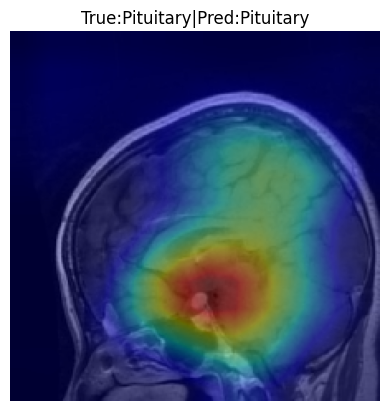

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


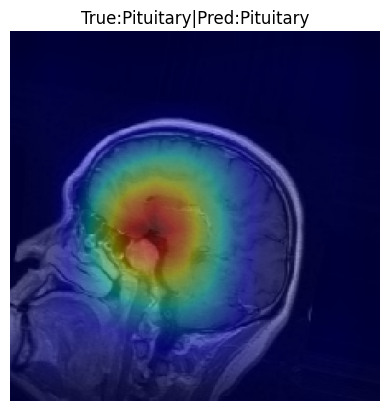

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


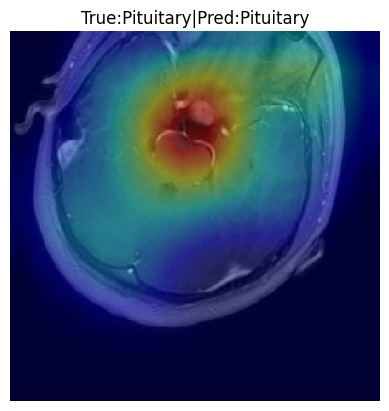

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


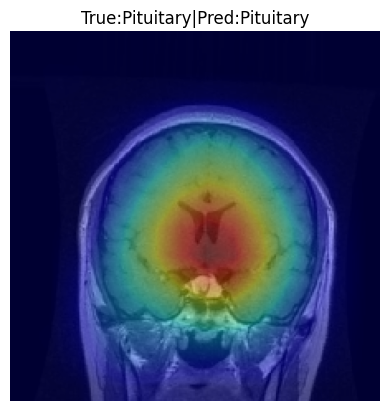

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


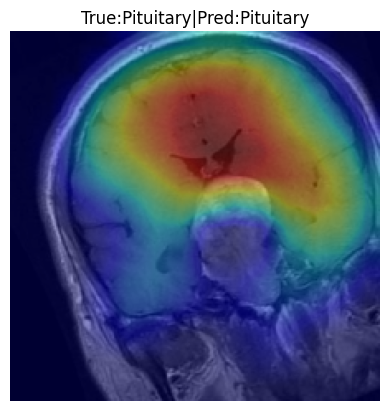

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


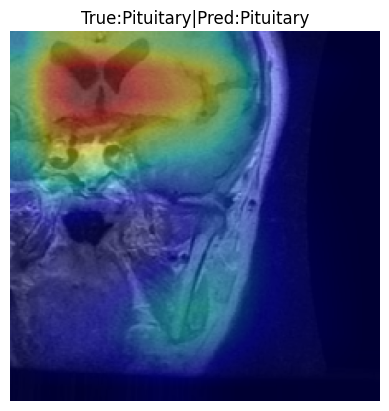

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


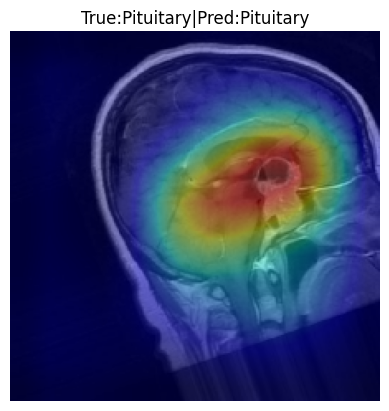

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


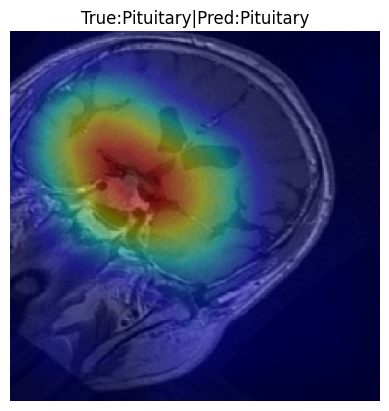

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


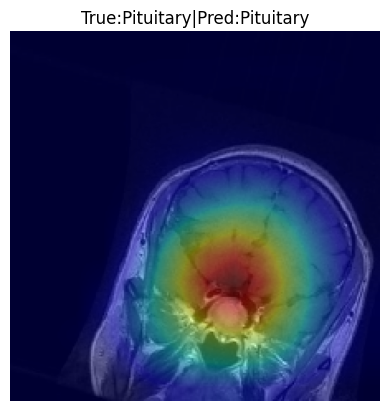

In [ ]:
#=======================================
# Grad CAM visualization
#=======================================

for i in range(1,10):
  img_path=df['path'].iloc[i]

  img=tf.keras.preprocessing.image.load_img(img_path,target_size=(224,224))

  img_array=tf.keras.preprocessing.image.img_to_array(img)/255
  img_array=np.expand_dims(img_array,0)
  # True label for dataFrame

  true_label=df['label'].iloc[i]
  preds=model.predict(img_array)
  pred_idx=np.argmax(preds)
  pred_label=class_label[pred_idx]

  heat=gradcam(model,img_array,layer_name='block5_conv3')

  plt.imshow(img)
  plt.imshow(heat,cmap='jet',alpha=0.4)
  plt.axis('off')
  plt.title(f'True:{true_label}|Pred:{pred_label}')
  plt.show()